# Finetune A Pretrained Model

Follow instructions: https://lightning.ai/lightning-ai/studios/quest-2-finetune-a-pretrained-model

In [7]:
!unzip leaf_dataset.zip 

Archive:  leaf_dataset.zip
   creating: leaf_dataset/
   creating: leaf_dataset/test/
   creating: leaf_dataset/test/ash/
  inflating: leaf_dataset/test/ash/image0.jpg  
  inflating: leaf_dataset/test/ash/image100.jpg  
  inflating: leaf_dataset/test/ash/image106.jpg  
  inflating: leaf_dataset/test/ash/image11.jpg  
  inflating: leaf_dataset/test/ash/image113.jpg  
  inflating: leaf_dataset/test/ash/image116.jpg  
  inflating: leaf_dataset/test/ash/image12.jpg  
  inflating: leaf_dataset/test/ash/image122.jpg  
  inflating: leaf_dataset/test/ash/image13.jpg  
  inflating: leaf_dataset/test/ash/image145.jpg  
  inflating: leaf_dataset/test/ash/image149.jpg  
  inflating: leaf_dataset/test/ash/image165.jpg  
  inflating: leaf_dataset/test/ash/image168.jpg  
  inflating: leaf_dataset/test/ash/image176.jpg  
  inflating: leaf_dataset/test/ash/image18.jpg  
  inflating: leaf_dataset/test/ash/image183.jpg  
  inflating: leaf_dataset/test/ash/image184.jpg  
  inflating: leaf_dataset/test/ash

In [3]:
pip install fastai --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install -qq timm
!pip install -qq torchsummary

In [2]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

from fastai.vision.all import *

In [3]:
!ls ~/leaf_dataset

test  train


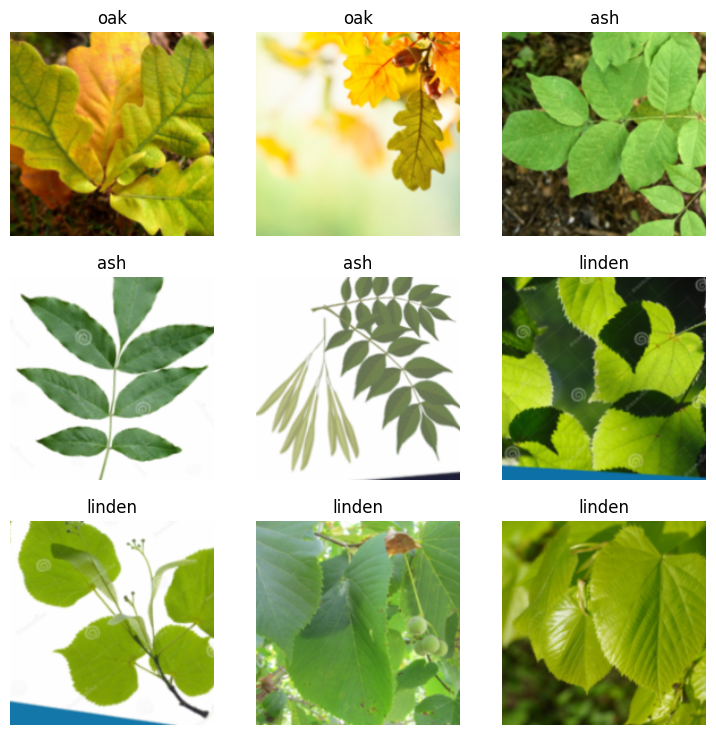

In [4]:
from fastai.vision.all import *
from pathlib import Path

path = Path.home() / 'leaf_dataset' / 'train'

dls = ImageDataLoaders.from_folder(
    path,                 # Path to the train folder
    train='.',            # Use the entire train folder for splitting
    valid_pct=0.2,        # 20% of the data will be used for validation
    seed=42,              # Set a seed for reproducibility
    item_tfms=Resize(224),# Resize the images to 224 (460 is too big) 
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Data augmentation 
    bs=16                 # Batch size 16
)

dls.show_batch(max_n=9)

In [5]:
import warnings

# to ignore the palette warnings
warnings.filterwarnings(
    "ignore",
    message="Palette images with Transparency expressed in bytes should be converted to RGBA images",
    category=UserWarning
)

Training the model. Model choosed is convnext_base - some weird results with really low optimal learning rate

In [6]:
from timm import list_models
list_models(pretrained=True)
learn = vision_learner(dls, convnext_base, metrics=error_rate)
learn.to_fp16()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0005754399462603033)

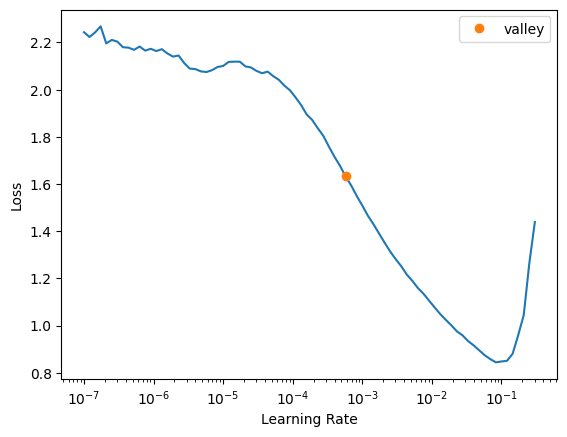

In [30]:
learn.lr_find()

In [7]:
lr =  0.00057543994 # setting optimal learning rate suggested by lr_find
epochs =  5 #dataset is relatively small so let's try on smaller number of epochs 

In [8]:
torch.cuda.empty_cache()

In [9]:
learn = vision_learner(dls, convnext_base, metrics=error_rate)
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.339410,0.364120,0.158416,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.637924,0.188472,0.089109,00:20
1,0.511014,0.139221,0.039604,00:21
2,0.419831,0.130295,0.059406,00:20
3,0.367057,0.114438,0.039604,00:20
4,0.320361,0.109034,0.039604,00:20


We can see that if we chose error_rate change as a stopping criterion we would've stopped after 2. epoch 

Evaluating the model's performance

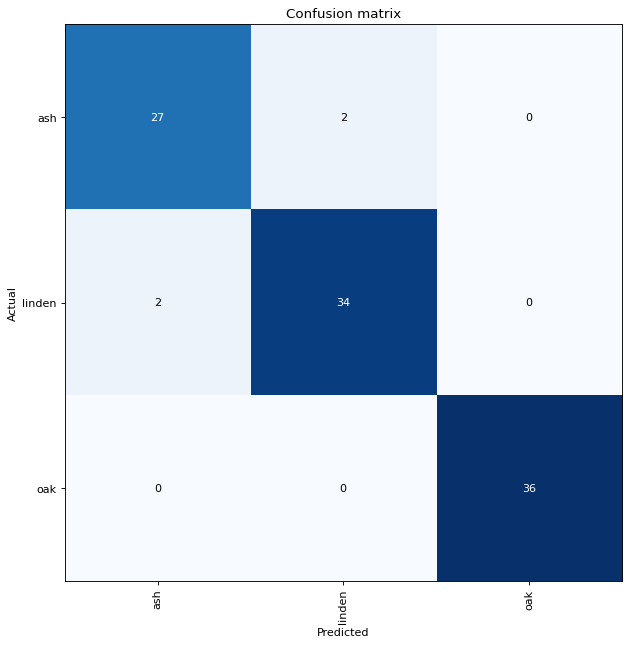

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

We can see that we basically mistaken 2 images of ash

Let's take a look on misclassified images

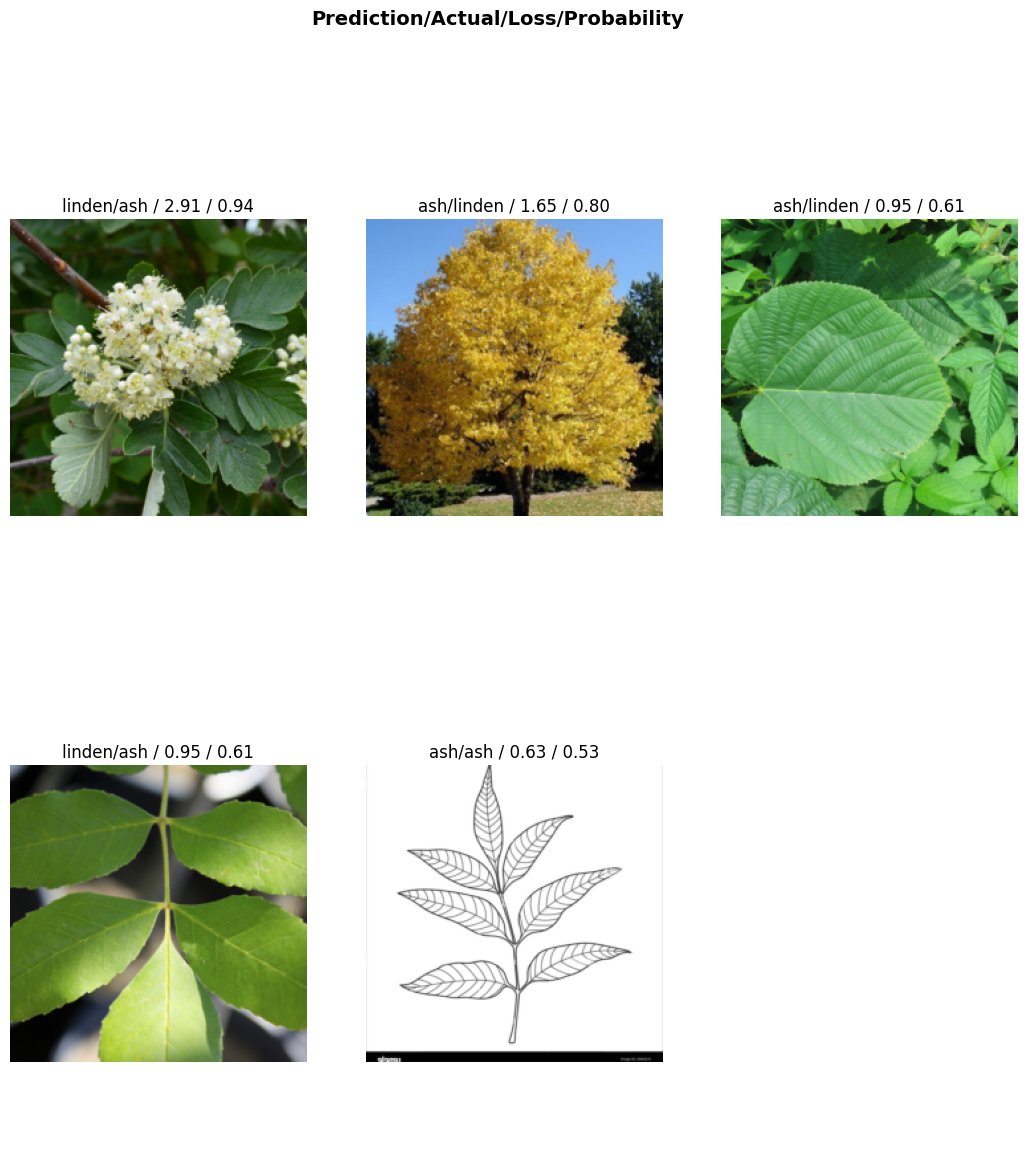

In [12]:
interp.plot_top_losses(5, figsize=(13,13))

Deleating those 4 confusing images

In [14]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
print(len(cleaner.delete()))

Testing on the test dataset

In [15]:
# Create a test DataLoader
test_path = Path.home() / 'leaf_dataset'  / 'test'
test_dl = learn.dls.test_dl(get_image_files(test_path))

In [16]:
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)

In [17]:
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]
from statistics import mean

In [18]:

from statistics import mean

print("Test error rate:")
print(1 - mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)]))

Test error rate:
0.02941176470588236


In [19]:
#saving the model

learn.export('leaf_model.pkl')